# <div style="font-family: Trebuchet MS; background-color: #58D68D; color: #000000; padding: 12px; line-height: 1.5; font-size:"> Introduction 🎻</div>

### <div style="font-family: Trebuchet MS; background-color: #F4D03F; color: #000000; padding: 12px; line-height: 1.5;"> Hey Kagglers!! Today I am gonna share with you a simple tool that you can leverage to speeden up the big data processing involved in your own projects. For freshers/experienced practioners, I believe that it is important for y'all to get a basic understanding of the Spark ecosystem as many data-centric companies are continuing to adopt this technology.<br><br> In this notebook, I have tried to compile all the basic functionalities to get you started with Spark effortlessly.</div>

<div style="font-family: Trebuchet MS; background-color: #EAECEE; color: #000000; padding: 12px; line-height: 1;"><h3> Some basic guidelines that I have followed to make this notebook look interactive:</h3><h4><ul style=“list-style-type:square”><li>Whenever there is a definition, I have highlighted it with a  <span style="background-color: #2E31FD;font-size: 25px">📣</span></li><br><li>Whenever there is a new function/method, I have highlighted it with a <span style="background-color: #00FF00;font-size: 25px">🌼</span></li><br><li>Whenever there is a suggestion from my side, I have highlighted it with a <span style="background-color: #F3FF00;font-size: 25px">📌</span></li></ul></h4></div> 

### So what are you waiting for! Let's get started with the basics:

## <div style="padding: 12px"><span style="background-color: #2E31FD;font-size: 35px">📣</span> What is Apache Spark in Technical terms.</div>

- Apache Spark is an open-source, distributed data processing and analytics framework designed for large-scale data processing tasks. 

- It provides a unified and flexible platform for performing various data processing operations, including batch processing, interactive queries, real-time stream processing, machine learning, and graph processing.

## <div style="padding: 12px"><span style="background-color: #2E31FD;font-size: 35px">📣</span> What is this Apache Spark with a simple analogy? </div>

- Apache Spark is like a supercharged engine for processing and analyzing really big piles of data. Imagine you have a massive amount of information, like a gigantic puzzle with millions of pieces. Trying to solve this puzzle on a single computer could take forever. But Spark lets you use many computers at once, like a team of puzzle solvers, to work on different parts of the puzzle together.

- These "puzzle solvers" (computers) can talk to each other and share their findings, making the work faster and more efficient. Spark also keeps everything organized and makes sure that even if one of the "puzzle solvers" takes a break or has a problem, the others can still continue working without losing progress.

- In simple words, Apache Spark helps you process huge amounts of data much faster by getting a bunch of computers to work together and collaborate on the job. It's like a team effort that makes solving big data problems much easier and quicker!

## <div style="padding: 12px"><span style="background-color: #2E31FD;font-size: 35px">📣</span> What is PySpark?</div>

- PySpark is the Python API to use Spark, just like Pandas.

- In simple words, PySpark is a special tool that combines the power of many computers with the simplicity of Python to help you handle really big piles of data without breaking a sweat!

## <div style="padding: 12px"><span style="background-color: #2E31FD;font-size: 35px">📣</span> Benefits of using PySpark over Pandas for Data Processing:</div>

#### 1. Scalability and Distributed Computing:

- PySpark is designed for processing large-scale data across clusters of machines. It can handle data sizes that may not fit in memory, as it utilizes distributed computing.
- Pandas, on the other hand, is designed for single-machine data processing and may struggle with extremely large datasets that exceed available memory.

#### 2. Performance:

- PySpark's in-memory processing and distributed computing can lead to better performance for certain operations on large datasets compared to pandas.
- While pandas is fast for single-machine operations, PySpark's parallel processing can provide significant performance gains for operations that can be parallelized across multiple nodes.

# <div style="font-family: Trebuchet MS; background-color: #B0E0E6; color: #000000; padding: 12px; line-height: 1.5;"> Importing Libraries 📚</div>

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import regex as re
import os

## Supressing warnings:
import warnings
warnings.filterwarnings("ignore")

In [146]:
!pip install pyspark

In [195]:
## importing essential spark libraries:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, count, when, regexp_replace, udf, struct, regexp_replace, lit, isnull, trim, asc, desc
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType

# <div style="font-family: Trebuchet MS; background-color: #B0E0E6; color: #000000; padding: 12px; line-height: 1.5;"> Getting Started with the Analysis 🔬</div>


#### The first step towards your adventure in Spark is to create a Spark Session. It is the entry point to the Spark ecosystem. Once you<br><br>reach the Spark environment via the entry point, you can freely create and manipulate Spark RDDs, Dataframes and Datasets. 

## <span style="background-color: #2E31FD;font-size: 35px">📣</span> What is a RDD?

You might be wondering what this new term is. Well RDD stands for **Resilient Distributed Dataset**. It is the fundamental data structure of Spark.

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> SparkSession.builder()

#### SparkSession will be created using SparkSession.builder() builder patterns::

In [148]:
##  Creating a Spark session:
spark = SparkSession.builder.appName('Sample').getOrCreate()

23/08/21 07:21:45 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [149]:
## Quick glance at the object
spark

##### Here, the spark object acts as the gateway to the Spark ecosystem. 

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> read.csv(), show()

To read a csv file.

In [150]:
df=spark.read.csv("/kaggle/input/food-delivery-dataset/train.csv",
                  header=True,
                  inferSchema=True)
#  Parameters:
## - inferSchema parameter ensures that the data formatting stays the same as the original dataframe. If False, then the 
##     columns will be of class string.
## - header parameter tells that the columns names are provided along with the dataset.

## Displaying the first 5 rows:
df.show(5)

+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+--------------------+--------------------+-----------------+-------------+---------------+-------------------+--------+--------------+---------------+
|     ID|Delivery_person_ID|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|  Time_Order_picked|   Weatherconditions|Road_traffic_density|Vehicle_condition|Type_of_order|Type_of_vehicle|multiple_deliveries|Festival|          City|Time_taken(min)|
+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+--------------------+--------------------+-----------------+-----

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> toPandas(), head()

To view the dataframe in the form of Pandas dataframe fashion.

In [151]:
## To convert a spark dataframe into a pandas dataframe
df.toPandas().head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,2023-08-21 11:45:00,conditions Sunny,High,2,Snack,motorcycle,0.0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,2023-08-21 19:50:00,conditions Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,2023-08-21 08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,2023-08-21 18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,2023-08-21 13:45:00,conditions Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,(min) 30


#### As you can see above, Time_taken(min) is the target variable.

#### Now we have read the csv file into Spark. Lets view the dataframe:

In [152]:
## Viewing the type
type(df)

pyspark.sql.dataframe.DataFrame

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> printSchema()

To print the schema of the dataset.

In [153]:
## Printing the attributes of the table:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Delivery_person_ID: string (nullable = true)
 |-- Delivery_person_Age: double (nullable = true)
 |-- Delivery_person_Ratings: double (nullable = true)
 |-- Restaurant_latitude: double (nullable = true)
 |-- Restaurant_longitude: double (nullable = true)
 |-- Delivery_location_latitude: double (nullable = true)
 |-- Delivery_location_longitude: double (nullable = true)
 |-- Order_Date: string (nullable = true)
 |-- Time_Orderd: string (nullable = true)
 |-- Time_Order_picked: timestamp (nullable = true)
 |-- Weatherconditions: string (nullable = true)
 |-- Road_traffic_density: string (nullable = true)
 |-- Vehicle_condition: integer (nullable = true)
 |-- Type_of_order: string (nullable = true)
 |-- Type_of_vehicle: string (nullable = true)
 |-- multiple_deliveries: double (nullable = true)
 |-- Festival: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Time_taken(min): string (nullable = true)



In [154]:
## Displaying the first 5 rows in the form of col-value pairs
df.head(5)

[Row(ID='0x4607 ', Delivery_person_ID='INDORES13DEL02 ', Delivery_person_Age=37.0, Delivery_person_Ratings=4.9, Restaurant_latitude=22.745049, Restaurant_longitude=75.892471, Delivery_location_latitude=22.765049, Delivery_location_longitude=75.912471, Order_Date='19-03-2022', Time_Orderd='11:30:00', Time_Order_picked=datetime.datetime(2023, 8, 21, 11, 45), Weatherconditions='conditions Sunny', Road_traffic_density='High ', Vehicle_condition=2, Type_of_order='Snack ', Type_of_vehicle='motorcycle ', multiple_deliveries=0.0, Festival='No ', City='Urban ', Time_taken(min)='(min) 24'),
 Row(ID='0xb379 ', Delivery_person_ID='BANGRES18DEL02 ', Delivery_person_Age=34.0, Delivery_person_Ratings=4.5, Restaurant_latitude=12.913041, Restaurant_longitude=77.683237, Delivery_location_latitude=13.043041, Delivery_location_longitude=77.813237, Order_Date='25-03-2022', Time_Orderd='19:45:00', Time_Order_picked=datetime.datetime(2023, 8, 21, 19, 50), Weatherconditions='conditions Stormy', Road_traffic_d

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> describe(), summary()

To view the basic statistics of the dataset.

In [155]:
## Basic statistics of the data:
df.describe()    ### df.summary()
df.describe().show()

+-------+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-----------------+--------------------+------------------+-------------+---------------+-------------------+--------+--------------+---------------+
|summary|     ID|Delivery_person_ID|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|Weatherconditions|Road_traffic_density| Vehicle_condition|Type_of_order|Type_of_vehicle|multiple_deliveries|Festival|          City|Time_taken(min)|
+-------+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-----------------+--------------------+------------------+-------------+---------------+-----------------

#### NOTE: describe() represents the statistical summary of dataframe but it also uses the string variables

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> count(), columns

To count the number of rows present, To display the various columns present in the dataframe.

In [156]:
## Shape of the dataframe is:
df.count(),len(df.columns)

(45593, 20)

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> col(), isNull(), alias()

To select a particular column for applying a transformation, To check whether a column has Null values, To rename a column after a transformation.

In [157]:
## Checking for null values:
df.select([count(when(df[c].isNull(), c)).alias(c) for c in df.columns]).show()

+---+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-----------------+-----------------+--------------------+-----------------+-------------+---------------+-------------------+--------+----+---------------+
| ID|Delivery_person_ID|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|Time_Order_picked|Weatherconditions|Road_traffic_density|Vehicle_condition|Type_of_order|Type_of_vehicle|multiple_deliveries|Festival|City|Time_taken(min)|
+---+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-----------------+-----------------+--------------------+-----------------+-------------+---------------+-------------------+--

### <span style="background-color: #F3FF00;font-size: 35px">📌</span>Breaking down the above query by taking one sample column:

In [158]:
## Then when-otherwise pair effectively works as the CASE WHEN THEN ELSE END expression of SQL:
df.select((when(df['Weatherconditions'].isNull(),"None").otherwise(df['Weatherconditions']))).show(2)

+--------------------------------------------------------------------------+
|CASE WHEN (Weatherconditions IS NULL) THEN None ELSE Weatherconditions END|
+--------------------------------------------------------------------------+
|                                                          conditions Sunny|
|                                                         conditions Stormy|
+--------------------------------------------------------------------------+
only showing top 2 rows



In [159]:
## Placing the alias changes the column name:
df.select((when(df['Weatherconditions'].isNull(),"None").otherwise(df['Weatherconditions'])).alias('Weatherconditions')).show(2)

+-----------------+
|Weatherconditions|
+-----------------+
| conditions Sunny|
|conditions Stormy|
+-----------------+
only showing top 2 rows



In [160]:
## Placing a count() function returns the number of empty/None/Null rows:
df.select(count(when(df['Weatherconditions'].isNull(),"None")).alias("Count_Null_Weather")).show(2)

## Automating this expression for multiple columns using the list comprehension will yield the desired output.

+------------------+
|Count_Null_Weather|
+------------------+
|                 0|
+------------------+



#### Looks like there are no null values.

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> dtypes

To view the datatypes of a column(s).

In [161]:
## Checking the dtypes:
df.dtypes

[('ID', 'string'),
 ('Delivery_person_ID', 'string'),
 ('Delivery_person_Age', 'double'),
 ('Delivery_person_Ratings', 'double'),
 ('Restaurant_latitude', 'double'),
 ('Restaurant_longitude', 'double'),
 ('Delivery_location_latitude', 'double'),
 ('Delivery_location_longitude', 'double'),
 ('Order_Date', 'string'),
 ('Time_Orderd', 'string'),
 ('Time_Order_picked', 'timestamp'),
 ('Weatherconditions', 'string'),
 ('Road_traffic_density', 'string'),
 ('Vehicle_condition', 'int'),
 ('Type_of_order', 'string'),
 ('Type_of_vehicle', 'string'),
 ('multiple_deliveries', 'double'),
 ('Festival', 'string'),
 ('City', 'string'),
 ('Time_taken(min)', 'string')]

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> select()

To select columns for display.

In [162]:
## To view a few selected columns:
df.select(["ID","Delivery_person_ID"]).show()

+-------+------------------+
|     ID|Delivery_person_ID|
+-------+------------------+
|0x4607 |   INDORES13DEL02 |
|0xb379 |   BANGRES18DEL02 |
|0x5d6d |   BANGRES19DEL01 |
|0x7a6a |  COIMBRES13DEL02 |
|0x70a2 |   CHENRES12DEL01 |
|0x9bb4 |    HYDRES09DEL03 |
|0x95b4 | RANCHIRES15DEL01 |
|0x9eb2 |    MYSRES15DEL02 |
|0x1102 |    HYDRES05DEL02 |
|0xcdcd |    DEHRES17DEL01 |
|0xd987 |    KOCRES16DEL01 |
|0x2784 |   PUNERES13DEL03 |
|0xc8b6 |   LUDHRES15DEL02 |
|0xdb64 |    KNPRES14DEL02 |
|0x3af3 |    MUMRES15DEL03 |
|0x3aab |    MYSRES01DEL01 |
|0x689b |   PUNERES20DEL01 |
|0x6f67 |    HYDRES14DEL01 |
|0xc9cf |    KOLRES15DEL03 |
|0x36b8 |   PUNERES19DEL02 |
+-------+------------------+
only showing top 20 rows



In [163]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Delivery_person_ID: string (nullable = true)
 |-- Delivery_person_Age: double (nullable = true)
 |-- Delivery_person_Ratings: double (nullable = true)
 |-- Restaurant_latitude: double (nullable = true)
 |-- Restaurant_longitude: double (nullable = true)
 |-- Delivery_location_latitude: double (nullable = true)
 |-- Delivery_location_longitude: double (nullable = true)
 |-- Order_Date: string (nullable = true)
 |-- Time_Orderd: string (nullable = true)
 |-- Time_Order_picked: timestamp (nullable = true)
 |-- Weatherconditions: string (nullable = true)
 |-- Road_traffic_density: string (nullable = true)
 |-- Vehicle_condition: integer (nullable = true)
 |-- Type_of_order: string (nullable = true)
 |-- Type_of_vehicle: string (nullable = true)
 |-- multiple_deliveries: double (nullable = true)
 |-- Festival: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Time_taken(min): string (nullable = true)



### <span style="background-color: #00FF00;font-size: 35px">🌼</span> cast()

To change the datatype of a column(s).

#### The various datatypes that a column can take up are integers, string, double, float, timestamp, etc...

#### To convert a column into:

1. double ---> use DoubleType()

2. int    ---> use IntegerType()

3. float  ---> use FloatType()

4. string ---> use StringType()

5. long   ---> use LongType()

#### all inside the cast() method.

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> withColumn()

#### In PySpark, the withColumn() function is widely used and defined as the **transformation function** of the DataFrame

#### which is further

- used to change the value, 

- convert the datatype of an existing column, 

- create the new column etc...

In [164]:
## Have to correct the datatypes of some columns. Delivery_person_Age, Vehicle_condition, multiple_deliveries
df=df.withColumn('Delivery_person_Age',col('Delivery_person_Age').cast(IntegerType()))\
.withColumn('Vehicle_condition',col('Vehicle_condition').cast(IntegerType()))\
.withColumn('multiple_deliveries',col('multiple_deliveries').cast(IntegerType()))

In [165]:
## Checking after conversion:
df.dtypes

[('ID', 'string'),
 ('Delivery_person_ID', 'string'),
 ('Delivery_person_Age', 'int'),
 ('Delivery_person_Ratings', 'double'),
 ('Restaurant_latitude', 'double'),
 ('Restaurant_longitude', 'double'),
 ('Delivery_location_latitude', 'double'),
 ('Delivery_location_longitude', 'double'),
 ('Order_Date', 'string'),
 ('Time_Orderd', 'string'),
 ('Time_Order_picked', 'timestamp'),
 ('Weatherconditions', 'string'),
 ('Road_traffic_density', 'string'),
 ('Vehicle_condition', 'int'),
 ('Type_of_order', 'string'),
 ('Type_of_vehicle', 'string'),
 ('multiple_deliveries', 'int'),
 ('Festival', 'string'),
 ('City', 'string'),
 ('Time_taken(min)', 'string')]

In [166]:
df.select(['Delivery_person_Age','Vehicle_condition','multiple_deliveries']).dtypes

[('Delivery_person_Age', 'int'),
 ('Vehicle_condition', 'int'),
 ('multiple_deliveries', 'int')]

In [167]:
## To display the PySpark dataframe as a pandas dataframe:
df.toPandas().head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,2023-08-21 11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,2023-08-21 19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,2023-08-21 08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,2023-08-21 18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,2023-08-21 13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [168]:
## Checking the numeric columns:
def num_cols(dataframe):
    num_cols = [col for col in dataframe.columns if dataframe.select(col).dtypes[0][1] in ['double', 'int']]
    return num_cols

num_cols = num_cols(df)  ### list of numeric columns
    
df.describe(num_cols).show()

+-------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+------------------+-------------------+
|summary|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude| Vehicle_condition|multiple_deliveries|
+-------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+------------------+-------------------+
|  count|              45593|                  45593|              45593|               45593|                     45593|                      45593|             45593|              45593|
|   mean| 28.364814774197793|                    NaN| 17.017728506525582|   70.23133233807862|        17.465185865088966|          70.84570225567651|  1.02335884894611| 0.7284451560546575|
| stddev|  8.157529884739837|                    NaN|  

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> distinct()

To get the unique values.

In [169]:
### There are 1320 unique IDs
df.select('Delivery_person_ID').distinct().count()  

1320

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> orderBy()

To sort a column(s).

In [170]:
### Counts of unique delivery person ids::
df.select('Delivery_person_ID').distinct().show(5)  ### 20 
df.groupBy('Delivery_person_ID').count().orderBy('count').show(5)

+------------------+
|Delivery_person_ID|
+------------------+
|    SURRES11DEL01 |
|    GOARES02DEL01 |
|    KNPRES09DEL03 |
|    KOCRES02DEL01 |
|    KOLRES08DEL01 |
+------------------+
only showing top 5 rows

+------------------+-----+
|Delivery_person_ID|count|
+------------------+-----+
|   BHPRES010DEL03 |    5|
|    KOCRES16DEL03 |    6|
|    KOLRES09DEL03 |    6|
|   AURGRES13DEL03 |    7|
|    GOARES01DEL03 |    7|
+------------------+-----+
only showing top 5 rows



## <div style="color:white;display:fill;border-radius:5px;background-color:#DE3163;font-size:110%;font-family:Verdana;letter-spacing:0.5px"><p style="padding: 10px;color:white;">Visualising the Distributions</p></div>

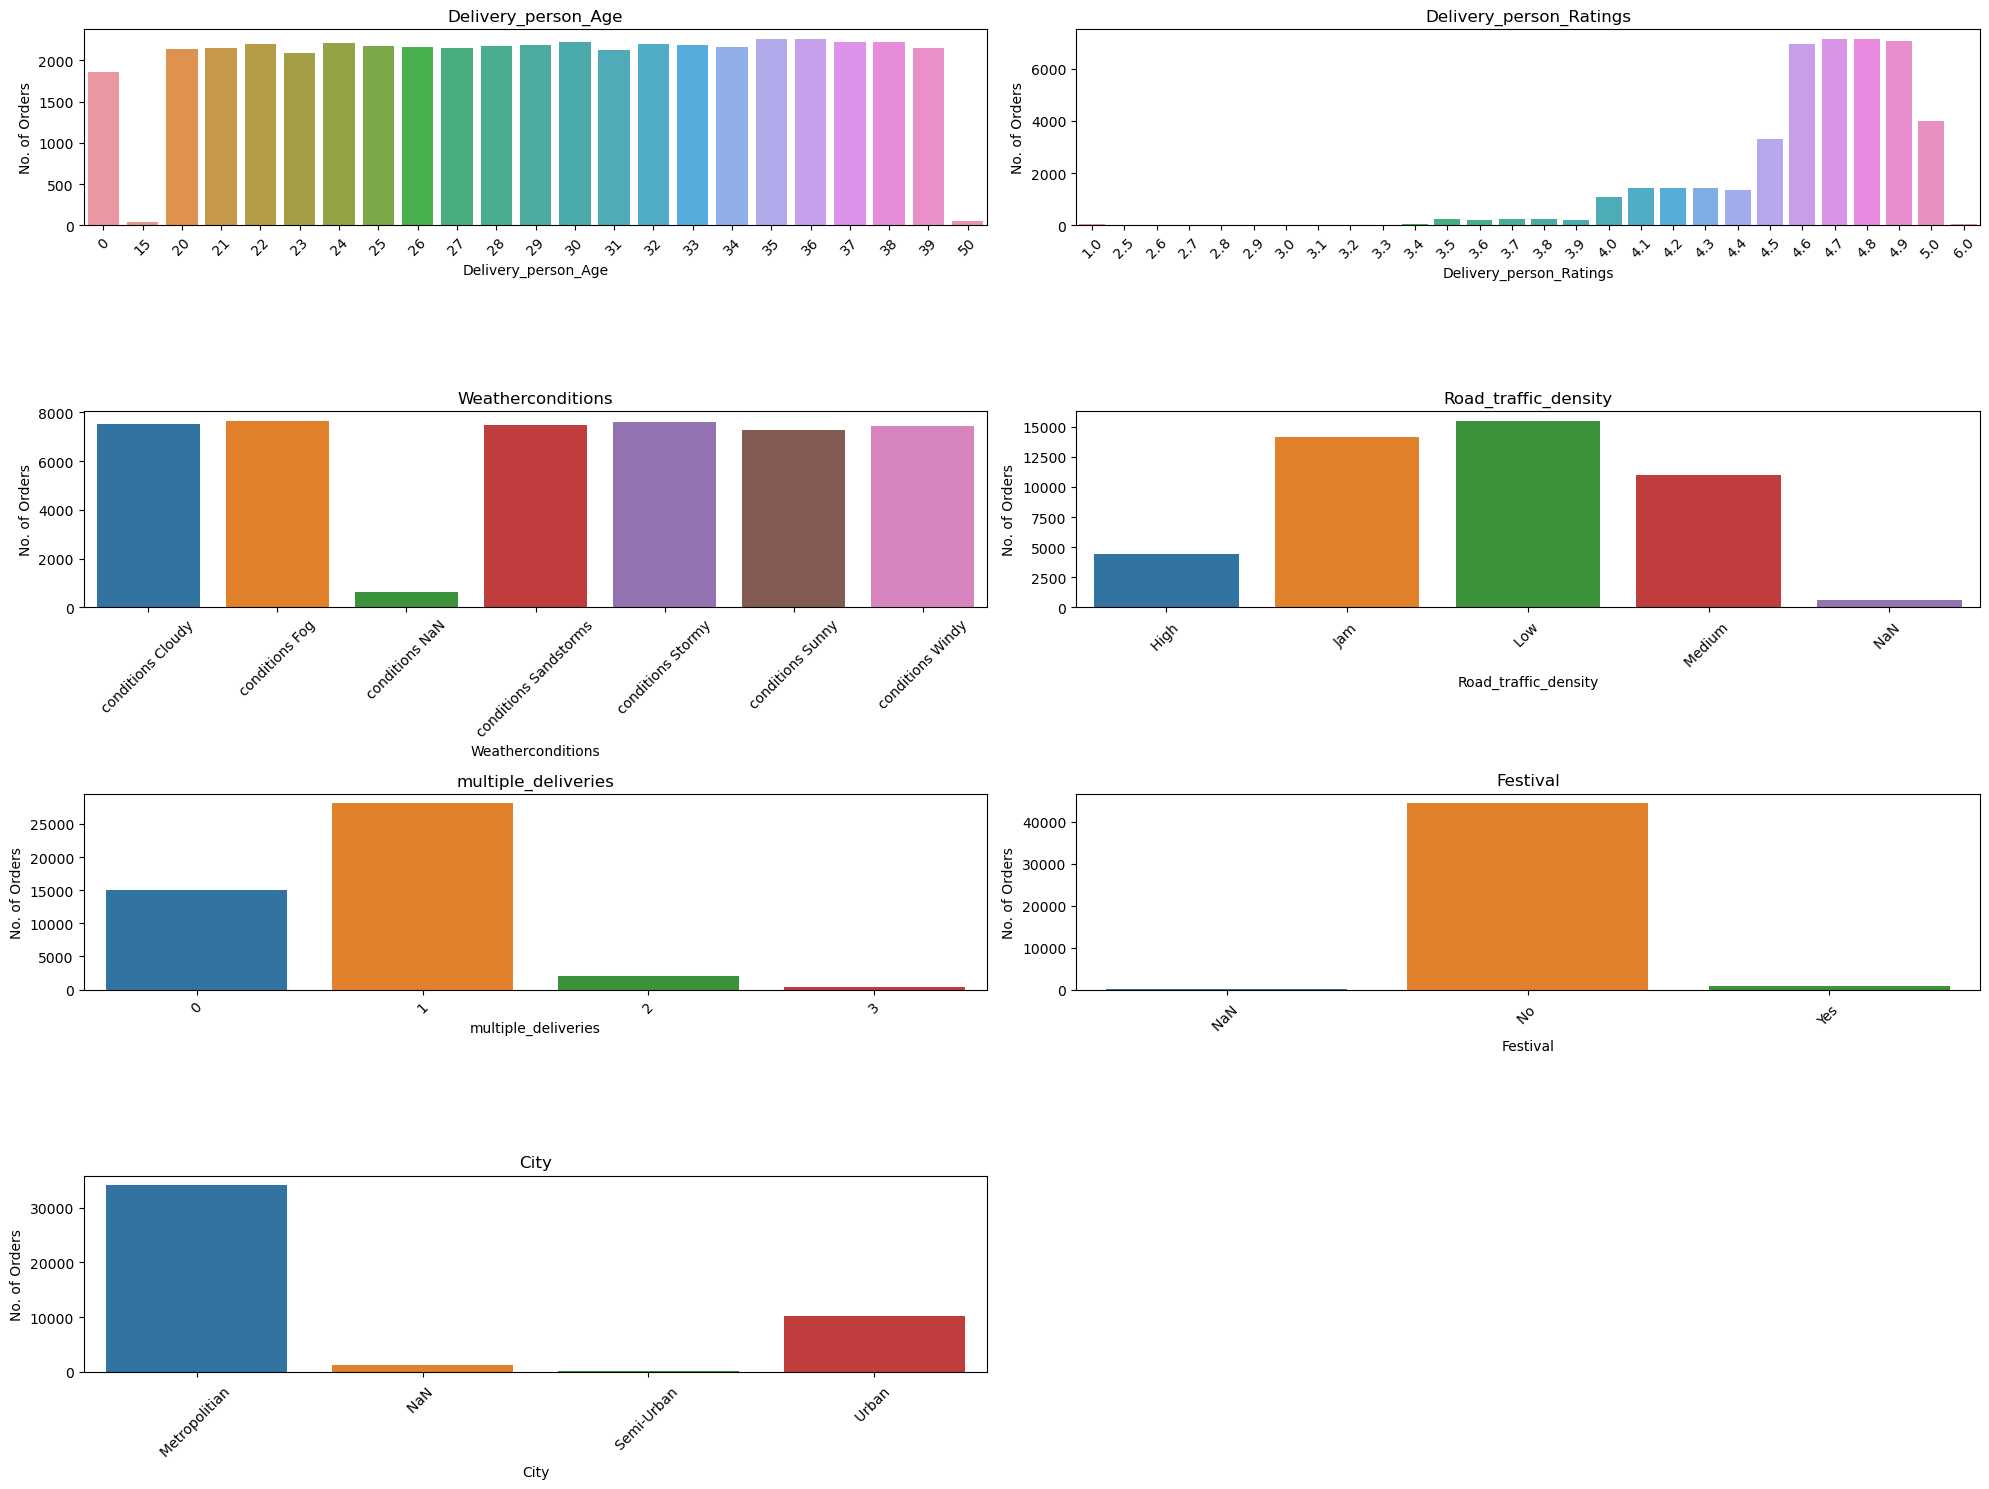

In [171]:
#Visualisating the distribution of the categorical variables:
cols = ['Delivery_person_Age','Delivery_person_Ratings','Weatherconditions','Road_traffic_density','multiple_deliveries','Festival','City']
num_plots = len(cols)
num_rows = (num_plots // 2) + (num_plots % 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(20,15))

for i, column_name in enumerate(cols):
    row = i // 2
    col = i % 2

    ax = axes[row, col]
    sns.countplot(data=df.toPandas(), x=column_name, order=df.toPandas()[column_name].value_counts().sort_index().index, ax=ax)

    ax.set_xlabel(column_name)
    ax.set_ylabel('No. of Orders')
    ax.set_title(column_name)
    ax.tick_params(axis='x', rotation=45)
    
if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

### The Delivery_person_Age column contains Age=0 values which are clearly outliers.

### Looks like we have to handle all the missing values. We can notice that although the data showed no missing values initially, it seems that the NaN values have been represented as a string, hence the isNa() function wasnt able to detect it earlier. 

### We can also bin categories as well!

In [172]:
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()
address = [(1,"14851 Jeffrey Rd","DE"),
    (2,"Address nan ","NY"),
    (3,"13111 Siemon Ave","CA"),
    (4,"bougain nan ","WA")]
sample =spark.createDataFrame(address,["id","address","state"])
sample.show()

23/08/21 07:22:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+---+----------------+-----+
| id|         address|state|
+---+----------------+-----+
|  1|14851 Jeffrey Rd|   DE|
|  2|    Address nan |   NY|
|  3|13111 Siemon Ave|   CA|
|  4|    bougain nan |   WA|
+---+----------------+-----+



### <span style="background-color: #00FF00;font-size: 35px">🌼</span> trim()

To remove trailing spaces.

In [173]:
### Stripping all the white space present in categorical columns:
cat=[i for i in df.columns if df.select(i).dtypes[0][1] in ('string')]
for i in cat:
    df=df.withColumn(i,trim(df[i]))

In [174]:
## checking whether rows are trimmed:
df.show(2)

+------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+-----------------+--------------------+-----------------+-------------+---------------+-------------------+--------+-------------+---------------+
|    ID|Delivery_person_ID|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|  Time_Order_picked|Weatherconditions|Road_traffic_density|Vehicle_condition|Type_of_order|Type_of_vehicle|multiple_deliveries|Festival|         City|Time_taken(min)|
+------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+-----------------+--------------------+-----------------+-------------+-----

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> regexp_replace()

To replace characters of a string.

In [178]:
cols = ['Delivery_person_Age','Delivery_person_Ratings','Weatherconditions','Road_traffic_density','multiple_deliveries','Festival','City']
for i in cols:
    ## Displaying the changes realtime
    ## NOTE: THE PARAMETER OF THE FUNCTION DOES NOT SUPPORT SQL-LIKE STRING MATCHING LIKE %,_,etc...
    df.withColumn(f"{i}_new",regexp_replace(i,"^(.*?)NaN","None")).select(f"{i}_new").distinct().show(25)
    ## Replacing the dataframe:
    df=df.withColumn(i,regexp_replace(i,"^(.*?)NaN","None"))

+-----------------------+
|Delivery_person_Age_new|
+-----------------------+
|                     15|
|                     29|
|                     30|
|                     34|
|                     22|
|                     28|
|                     35|
|                      0|
|                     31|
|                     27|
|                     26|
|                     23|
|                     38|
|                     25|
|                     33|
|                     24|
|                     32|
|                     20|
|                     36|
|                     37|
|                     39|
|                     21|
|                     50|
+-----------------------+

+---------------------------+
|Delivery_person_Ratings_new|
+---------------------------+
|                        1.0|
|                        2.6|
|                        3.1|
|                        4.2|
|                       None|
|                        4.4|
|                        3.

Now that we have temporarily replace the NaN values with "None", we will treat them later one-by-one in the upcoming sections.

In [179]:
df.select(df.Weatherconditions).distinct().show()

+--------------------+
|   Weatherconditions|
+--------------------+
|                None|
|conditions Sandst...|
|      conditions Fog|
|    conditions Windy|
|    conditions Sunny|
|   conditions Cloudy|
|   conditions Stormy|
+--------------------+



## <div style="color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:110%;font-family:Verdana;letter-spacing:0.5px"><p style="padding: 10px;color:white;">Feature Engineering Overview</p></div>
    
As observed from the above dataset, we can extract the following:

1. City from Delivery_person_ID ----> city  ✅

2. Bucket cities into Zones - North, South, East, West  ----> city_zone  ✅

3. Cleaning the Weatherconditions column

4. Time taken to pick up delivery using Time_Orderd and Time_Order_picked ----> pickup_time

5. Time of the day - Morning, Lunch, Evening, Night, Midnight ----> day_zone

6. To clean up target variable - Time_taken(min)  ✅

7. Bucket Age - Delivery_person_Age ----> life_stage

8. Features using Latitude and Longitude ----> geosidic

9. Handle NaN values in all column

<blockquote><p style="font-size:20px; color:#159364; font-family:verdana;">1. City from delivery id:</p></blockquote>

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> udf()

#### In order to apply a function into a particular column, we have create the function and register it as a UDF(User Defined Function) on Spark.

#### It is imported from the pyspark.sql.functions module.

In [183]:
# Create custom function
def city_extract(x):
    return re.findall("(\S+)RES\S+",x)[0]

# Convert the function as a UDF using the udf function:
city_extract_UDF = udf(lambda x:city_extract(x),StringType()) 

# Apply the function on the desired column:
df=df.withColumn("City_code",city_extract_UDF(df["Delivery_person_ID"]))

## Having a glance at the new column:
df.select(['Delivery_person_ID','City_code']).show(5)

+------------------+---------+
|Delivery_person_ID|City_code|
+------------------+---------+
|    INDORES13DEL02|     INDO|
|    BANGRES18DEL02|     BANG|
|    BANGRES19DEL01|     BANG|
|   COIMBRES13DEL02|    COIMB|
|    CHENRES12DEL01|     CHEN|
+------------------+---------+
only showing top 5 rows



In [184]:
## There are 22 unique city codes in our data:
df.select("City_code").distinct().show(22)

+---------+
|City_code|
+---------+
|     LUDH|
|     CHEN|
|      KOC|
|      GOA|
|     AURG|
|      JAP|
|      DEH|
|      MUM|
|      AGR|
|      SUR|
|     INDO|
|     PUNE|
|      ALH|
|      MYS|
|    COIMB|
|      HYD|
|      VAD|
|   RANCHI|
|      BHP|
|      KOL|
|      KNP|
|     BANG|
+---------+



### <span style="background-color: #00FF00;font-size: 35px">🌼</span> groupBy(), sort()--asc()/desc()

To group by the data based on column(s), To sort based on column(s) in ascending/descending fashion.

In [209]:
## To get count of the distinct cities:: (equivalent to value_counts() method in pandas)
df.groupBy("City_code").count().sort(col("count").desc()).show(22)  ### orderBy(desc(col("count")))  ## orderBy(desc("count")) ## orderBy('count', ascending=False) 

+---------+-----+
|City_code|count|
+---------+-----+
|      JAP| 3443|
|   RANCHI| 3229|
|     BANG| 3195|
|      SUR| 3187|
|      HYD| 3181|
|      MUM| 3173|
|      MYS| 3171|
|    COIMB| 3170|
|      VAD| 3166|
|     INDO| 3159|
|     CHEN| 3145|
|     PUNE| 3132|
|      AGR|  763|
|     LUDH|  758|
|      ALH|  740|
|      KNP|  740|
|      DEH|  737|
|      GOA|  709|
|     AURG|  703|
|      KOC|  701|
|      KOL|  700|
|      BHP|  691|
+---------+-----+



### <span style="background-color: #00FF00;font-size: 35px">🌼</span> rdd.flatMap().collect()

Methods to convert a pyspark column into a list/array:

In [210]:
df.select("City_code").distinct().rdd.flatMap(lambda x: x).collect()  ### to convert a column into a list
df.select("City_code").distinct().toPandas().values.flatten()  ### to convert a column into a numpy array

array(['LUDH', 'CHEN', 'KOC', 'GOA', 'AURG', 'JAP', 'DEH', 'MUM', 'AGR',
       'SUR', 'INDO', 'PUNE', 'ALH', 'MYS', 'COIMB', 'HYD', 'VAD',
       'RANCHI', 'BHP', 'KOL', 'KNP', 'BANG'], dtype=object)

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> withColumnRenamed()

To rename a column.

In [211]:
## Renaming the column to avoid name clash:
df=df.withColumnRenamed("City_code","City_short_form")

In [213]:
## Checking to see if change has reflected:
df.columns

['ID',
 'Delivery_person_ID',
 'Delivery_person_Age',
 'Delivery_person_Ratings',
 'Restaurant_latitude',
 'Restaurant_longitude',
 'Delivery_location_latitude',
 'Delivery_location_longitude',
 'Order_Date',
 'Time_Orderd',
 'Time_Order_picked',
 'Weatherconditions',
 'Road_traffic_density',
 'Vehicle_condition',
 'Type_of_order',
 'Type_of_vehicle',
 'multiple_deliveries',
 'Festival',
 'City',
 'Time_taken(min)',
 'City_short_form']

In [214]:
### Created a manual list of the full form of the city encodings:
dic_city={"LUDH":"Ludhiana",
"CHEN":"Chennai",
"KOC":"Kochi",
"GOA":"Goa",
"AURG":"Aurangabad",
"JAP":"Jaipur",
"DEH":"Delhi",
"MUM":"Mumbai",
"AGR":"Agra",
"SUR":"Surat",
"INDO":"Indore",
"PUNE":"Pune",
"ALH":"Allahabad",
"MYS":"Mysore",
"COIMB":"Coimbatore",
"HYD":"Hyderabad",
"VAD":"Vadodara",
"RANCHI":"Ranchi",
"BHP":"Bhopal",
"KOL":"Kolkatta",
"KNP":"Kanpur",
"BANG":"Bangalore"}

NOTE: You cannot pass dictionaries as a parameter for a UDF! Hence the below code cell will raise an error:

In [216]:
## Creating a udf to map the encodings with their original names:
def city_map(x,dic):
    return dic[x['City_short_form']]
udf_city_map=udf(lambda x:city_map(x,dic),StringType())
df=df.withColumn("City",udf_city_map(col("City_short_form")))

In [217]:
df.City.show(12)

TypeError: 'Column' object is not callable

Hence you have to make a small change in the way you define the function by creating a nested function for indirectly passing the dictionary as a parameter to the UDF:

In [219]:
def get_city(mapping):
    def f(x):
        return mapping.get(x)
    return udf(f)

df=df.withColumn('City', get_city(dic_city)(col('City_short_form')))

In [220]:
## Checking the dataset for the new column:
df.select("City").show(5)

+----------+
|      City|
+----------+
|    Indore|
| Bangalore|
| Bangalore|
|Coimbatore|
|   Chennai|
+----------+
only showing top 5 rows



<blockquote><p style="font-size:20px; color:#159364; font-family:verdana;">2. Bucketing cities into various Zones - North, South, East, West:</p></blockquote>

In [221]:
## NOTE: THIS IS COMPLETELY BASED ON MY INTUTION, PLZ CORRECT THIS, IF THERE ANY MISTAKES, IN YOUR OWN ANALYSIS:
dic_zones={"Ludhiana":"North",
"Chennai":"South",
"Kochi":"South",
"Goa":"West",
"Aurangabad":"West",
"Jaipur":"North",
"Delhi":"North",
"Mumbai":"West",
"Agra":"North",
"Surat":"East",
"Indore":"Central",
"Pune":"West",
"Allahabad":"North",
"Mysore":"South",
"Coimbatore":"South",
"Hyderabad":"South",
"Vadodara":"West",
"Ranchi":"North",
"Bhopal":"North",
"Kolkatta":"East",
"Kanpur":"North",
"Bangalore":"South"}

In [222]:
def get_zone(mapping):
    def f(x):
        return mapping.get(x)
    return udf(f)

df=df.withColumn('city_zone', get_zone(dic_zones)(col('City')))

In [223]:
## Checking the new columns:
df.select(["City","city_zone"]).show(5)

+----------+---------+
|      City|city_zone|
+----------+---------+
|    Indore|  Central|
| Bangalore|    South|
| Bangalore|    South|
|Coimbatore|    South|
|   Chennai|    South|
+----------+---------+
only showing top 5 rows



<blockquote><p style="font-size:20px; color:#159364; font-family:verdana;">3. Cleaning the Weatherconditions column:</p></blockquote>

In [224]:
df.select("Weatherconditions").show(5)

+--------------------+
|   Weatherconditions|
+--------------------+
|    conditions Sunny|
|   conditions Stormy|
|conditions Sandst...|
|    conditions Sunny|
|   conditions Cloudy|
+--------------------+
only showing top 5 rows



In [226]:
df.groupBy("Weatherconditions").count().sort(desc("count")).show()

+--------------------+-----+
|   Weatherconditions|count|
+--------------------+-----+
|      conditions Fog| 7654|
|   conditions Stormy| 7586|
|   conditions Cloudy| 7536|
|conditions Sandst...| 7495|
|    conditions Windy| 7422|
|    conditions Sunny| 7284|
|                None|  616|
+--------------------+-----+



Looks like there are None values as well. We will have to clean those **616** data points.

### To clean this, we will just randomly fill it with any weather as the distributions for all weather conditions are uniform.

<blockquote><p style="font-size:20px; color:#159364; font-family:verdana;">4. Getting Pickup time:</p></blockquote>

In [39]:
## equivalent value counts in python:
## Looks like there are ~1700 rows of null values in this column.
df.groupBy('Time_Orderd').count().sort(col("count").desc()).show(10)
# df.groupBy('Time_Orderd').count().sort(col("count").desc()).select("Time_Orderd").show(1)  ### To view the NaN string

+-----------+-----+
|Time_Orderd|count|
+-----------+-----+
|       NaN | 1731|
|   21:55:00|  461|
|   17:55:00|  456|
|   20:00:00|  449|
|   22:20:00|  448|
|   21:35:00|  446|
|   19:50:00|  444|
|   21:15:00|  442|
|   21:20:00|  438|
|   22:45:00|  438|
+-----------+-----+
only showing top 10 rows



In [40]:
df.select(df['Order_Date']=="NaN ").count()

45593

In [41]:
df.filter(df['Time_Orderd']=="NaN ").show()#.select(['Time_Orderd']).show()

+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+--------------------+--------------------+-----------------+-------------+-----------------+-------------------+--------+--------------+---------------+---------+---------+
|     ID|Delivery_person_ID|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|  Time_Order_picked|   Weatherconditions|Road_traffic_density|Vehicle_condition|Type_of_order|  Type_of_vehicle|multiple_deliveries|Festival|City_encodings|Time_taken(min)|     City|city_zone|
+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+--------------------+

### <span style="background-color: #00FF00;font-size: 35px">🌼</span> struct()

We use struct to pass multiple columns as an argument to a udf.

In [67]:
df.select(['Order_Date','Time_Orderd']).show()

## Creating a udf without an explicit function, and using multiple columns with the help of struct function::
order_timestamp_udf = udf(lambda x: x[0]+" "+x[1], StringType())
df.withColumn("order_time_timestamp",order_timestamp_udf(struct('Order_Date','Time_Orderd'))).select("order_time_timestamp").show(5)

+----------+-----------+
|Order_Date|Time_Orderd|
+----------+-----------+
|19-03-2022|   11:30:00|
|25-03-2022|   19:45:00|
|19-03-2022|   08:30:00|
|05-04-2022|   18:00:00|
|26-03-2022|   13:30:00|
|11-03-2022|   21:20:00|
|04-03-2022|   19:15:00|
|14-03-2022|   17:25:00|
|20-03-2022|   20:55:00|
|12-02-2022|   21:55:00|
|13-02-2022|   14:55:00|
|04-03-2022|   17:30:00|
|13-02-2022|   09:20:00|
|14-02-2022|   19:50:00|
|02-04-2022|   20:25:00|
|01-03-2022|   14:55:00|
|16-03-2022|   20:30:00|
|20-03-2022|   20:40:00|
|15-02-2022|   21:15:00|
|16-03-2022|   20:20:00|
+----------+-----------+
only showing top 20 rows

+--------------------+
|order_time_timestamp|
+--------------------+
| 19-03-2022 11:30:00|
| 25-03-2022 19:45:00|
| 19-03-2022 08:30:00|
| 05-04-2022 18:00:00|
| 26-03-2022 13:30:00|
+--------------------+
only showing top 5 rows



In [61]:
df.dtypes

[('ID', 'string'),
 ('Delivery_person_ID', 'string'),
 ('Delivery_person_Age', 'int'),
 ('Delivery_person_Ratings', 'double'),
 ('Restaurant_latitude', 'double'),
 ('Restaurant_longitude', 'double'),
 ('Delivery_location_latitude', 'double'),
 ('Delivery_location_longitude', 'double'),
 ('Order_Date', 'string'),
 ('Time_Orderd', 'string'),
 ('Time_Order_picked', 'timestamp'),
 ('Weatherconditions', 'string'),
 ('Road_traffic_density', 'string'),
 ('Vehicle_condition', 'int'),
 ('Type_of_order', 'string'),
 ('Type_of_vehicle', 'string'),
 ('multiple_deliveries', 'int'),
 ('Festival', 'string'),
 ('City_encodings', 'string'),
 ('Time_taken(min)', 'string'),
 ('City', 'string'),
 ('city_zone', 'string')]

In [43]:
df.groupBy('Time_Order_picked').count().sort(col("count").desc()).show(10)

+-------------------+-----+
|  Time_Order_picked|count|
+-------------------+-----+
|2023-08-20 21:30:00|  496|
|2023-08-20 22:50:00|  474|
|2023-08-20 22:40:00|  458|
|2023-08-20 18:40:00|  457|
|2023-08-20 21:45:00|  456|
|2023-08-20 17:55:00|  456|
|2023-08-20 22:25:00|  455|
|2023-08-20 18:05:00|  454|
|2023-08-20 23:50:00|  453|
|2023-08-20 20:50:00|  453|
+-------------------+-----+
only showing top 10 rows



As you can see there are NaN values in the 'Time_Orderd' attribute. We cannot calculate delivery time with NaNs in this column. How do we tackle this. ANY IDEAS?? Let me know your ideas in the comments.

### <span style="background-color: #F3FF00;font-size: 35px">📌</span>A go-to approach will be to calculate average pickup time using other non null rows and then imputing the null rows with the average obtained.

In [44]:
df.show()

+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+--------------------+--------------------+-----------------+-------------+-----------------+-------------------+--------+--------------+---------------+----------+---------+
|     ID|Delivery_person_ID|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|  Time_Order_picked|   Weatherconditions|Road_traffic_density|Vehicle_condition|Type_of_order|  Type_of_vehicle|multiple_deliveries|Festival|City_encodings|Time_taken(min)|      City|city_zone|
+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+-------------------

In [50]:
df.select("Time_Orderd").show(5)

+-----------+
|Time_Orderd|
+-----------+
|   11:30:00|
|   19:45:00|
|   08:30:00|
|   18:00:00|
|   13:30:00|
+-----------+
only showing top 5 rows



### <span style="background-color: #00FF00;font-size: 35px">🌼</span> filter()

You can filter using SQL like commands as well. I will display both the techniques:

In [54]:
## Non SQL method
df.filter(df["Time_Orderd"]!="NaN ").select(["Time_Orderd","Time_Order_picked"]).show(5)
df.filter(df["Time_Orderd"].like("%NaN%")).select(["Time_Orderd","Time_Order_picked"]).show(5)  ### similar to the SQL style of string matching

+-----------+-------------------+
|Time_Orderd|  Time_Order_picked|
+-----------+-------------------+
|   11:30:00|2023-08-20 11:45:00|
|   19:45:00|2023-08-20 19:50:00|
|   08:30:00|2023-08-20 08:45:00|
|   18:00:00|2023-08-20 18:10:00|
|   13:30:00|2023-08-20 13:45:00|
+-----------+-------------------+
only showing top 5 rows

+-----------+-------------------+
|Time_Orderd|  Time_Order_picked|
+-----------+-------------------+
|       NaN |2023-08-20 18:35:00|
|       NaN |2023-08-20 15:30:00|
|       NaN |2023-08-20 18:25:00|
|       NaN |2023-08-20 23:40:00|
|       NaN |2023-08-20 17:50:00|
+-----------+-------------------+
only showing top 5 rows



In [51]:
## SQL method
df.filter("Time_Orderd='NaN '").select(["Time_Orderd","Time_Order_picked"]).show(5)

+-----------+-------------------+
|Time_Orderd|  Time_Order_picked|
+-----------+-------------------+
|       NaN |2023-08-20 18:35:00|
|       NaN |2023-08-20 15:30:00|
|       NaN |2023-08-20 18:25:00|
|       NaN |2023-08-20 23:40:00|
|       NaN |2023-08-20 17:50:00|
+-----------+-------------------+
only showing top 5 rows



In [55]:
### Checking whether Weather NaNs are correlated with TimeOrderd:
df.filter("Time_Orderd='NaN ' and Weatherconditions like '%NaN%'").select(['Weatherconditions','Time_Orderd']).show(5)

+-----------------+-----------+
|Weatherconditions|Time_Orderd|
+-----------------+-----------+
|   conditions NaN|       NaN |
|   conditions NaN|       NaN |
|   conditions NaN|       NaN |
|   conditions NaN|       NaN |
|   conditions NaN|       NaN |
+-----------------+-----------+
only showing top 5 rows



In [59]:
df.filter("Weatherconditions like '%NaN%'").count(),df.filter("Time_Orderd='NaN '").count(),df.filter("Time_Orderd='NaN ' and Weatherconditions like '%NaN%'").count()

(616, 1731, 616)

From the above we can conclude that if the weather conditions of the place is unknown, then the order time is unknown.

i.e weather conditions is NaN ⇒ order time is NaN

In [ ]:
df.groupBy('Time_Orderd').count().sort(col("count").desc()).select("Time_Orderd").show(1)

<blockquote><p style="font-size:20px; color:#159364; font-family:verdana;">5. Splitting the time of ordering into zones of a day - Morning, Lunch, Evening, Night, Midnight:</p></blockquote>

In [ ]:
df.columns

In [ ]:
df.select('Time_Orderd').dtypes

<blockquote><p style="font-size:20px; color:#159364; font-family:verdana;">6. Cleaning the target variable:</p></blockquote>

In [ ]:
## Before transformation:
df.select("Time_taken(min)").show(5)

In [ ]:
## Renaming the column name::
df=df.withColumnRenamed('Time_taken(min)','time_taken')

## Removing the preffix (i.e. '(min)') in the column values with the help of a UDF:
def target_clean(x):
    return x[-2:]

target_clean_udf=udf(lambda x:target_clean(x),StringType())
df=df.withColumn("time_taken",target_clean_udf(col("time_taken")))
## Converting type:
df=df.withColumn("time_taken",col("time_taken").cast(IntegerType()))

In [ ]:
## As you can see, the values have been cleaned and the type has been changed:
df.select("time_taken").show(5),df.select("time_taken").dtypes

<blockquote><p style="font-size:20px; color:#159364; font-family:verdana;">7. Handling the Geo Data:</p></blockquote>

In [ ]:
7. 

# from geopy.distance import geodesic 

# train['distance_diff_KM']=np.zeros(len(train))
# restaurant_cordinates_train=train[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
# delivery_location_cordinates_train=train[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()

# for i in range(len(train)):
#     train['distance_diff_KM'].loc[i]=geodesic(restaurant_cordinates_train[i],delivery_location_cordinates_train[i])